In [ ]:
# !pip install -qU pyarrow polars catboost lightgbm

In [2]:
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs

import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, classification_report

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

import shap
shap.initjs()

## 0. Dataset load

In [3]:
DATA_PATH = '/kaggle/input/sber-salaraclient-churn-data/'

In [4]:
data = pl.read_parquet(DATA_PATH + 'data_cleaned.parquet')
data.head()

target,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature12,feature14,feature16,feature17,feature18,feature19,feature22,feature24,feature25,feature31,feature33,feature35,feature36,feature37,feature38,feature41,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature52,feature53,feature54,feature55,…,feature992,feature993,feature994,feature996,feature997,feature998,feature999,feature1000,feature1001,feature1002,feature1003,feature1004,feature1035,feature1036,feature1037,feature1038,feature1042,feature1043,feature1045,feature1049,feature1050,feature1051,feature1052,feature1053,feature1054,feature1055,feature1056,feature1057,feature1059,feature1063,feature1064,feature1065,feature1066,feature1067,feature1068,feature1069,feature1076
i8,i16,i16,i16,i32,i16,i16,i8,i16,i16,i16,i16,i16,i16,i8,i16,i32,i16,i16,i16,i32,i32,i16,i32,i16,i16,i32,i16,i16,i32,i32,i16,i16,i16,i16,i32,i32,…,i16,i16,i16,i8,i8,i8,i8,i8,i8,i16,i16,i16,i32,i32,i16,i32,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i16,i32,i32,i32,i32,i32,i32,i32,i32,i32
0,1761,1759,85,105469,191,46,0,6,95,20,1,50,60,7,248,91601,173,1722,633,50524,16130,3652,85495,14172,7705,19131,6511,12018,31287,27091,0,0,0,0,30270,27157,…,5,8,16,1,0,0,2,1,2,3,6,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12045,12107,12510,21126,28913,48985,84264,84264
0,1761,1759,120,105610,144,71,0,135,135,187,1,43,101,11,18,36890,184,1722,633,50524,18999,3652,85495,14172,7705,59900,6511,12018,116284,141739,0,0,0,0,112320,138924,…,4,10,22,0,0,0,3,0,2,3,9,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,890,1759,141,105227,191,11,0,0,0,187,1,0,0,28,248,140184,248,1722,633,50524,65748,3652,85495,14172,7705,11110,6511,12018,261217,284839,0,0,0,0,252909,278364,…,9,24,40,1,1,2,3,3,5,8,23,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33735,31242,12691,48682,55949,70006,113317,113317
0,1599,966,30,102441,191,8,0,0,0,187,1,0,0,28,248,140184,248,1722,633,50524,65748,3652,85495,81,7705,38606,6511,12018,303119,151593,0,0,0,0,293748,148572,…,5,5,5,1,1,1,2,2,3,3,3,3,12436,0,0,12329,101,0,114,0,0,0,0,0,0,0,5220,0,5810,0,0,0,0,0,6872,8530,8530
0,1761,1759,85,104006,191,2,0,0,46,2,1,1,21,3,248,140184,248,1722,633,16988,65748,3652,0,14172,7705,17927,6511,12018,245560,449478,0,0,0,0,237725,438447,…,6,12,14,1,1,0,3,1,3,4,10,12,27032,0,0,26719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7642,7642


In [5]:
n_unique_vals_by_col = data.drop(
    'target'
).select(
    pl.all().n_unique()
).transpose(
    include_header=True
).rename(
    {'column_0': 'n_unique'}
).sort(
    'n_unique'
)
n_unique_vals_by_col

column,n_unique
str,u32
"""feature242""",2
"""feature384""",2
"""feature385""",2
"""feature386""",2
"""feature387""",2
…,…
"""feature136""",501444
"""feature142""",501904
"""feature206""",502242


In [6]:
print('Data shape and size:', data.shape, round(data.estimated_size('gb'), 3))
print('Target info:', pl.Series(data.select(pl.col('target'))).value_counts())

Data shape and size: (519615, 641) 0.659
Target info: shape: (2, 2)
┌────────┬────────┐
│ target ┆ count  │
│ ---    ┆ ---    │
│ i8     ┆ u32    │
╞════════╪════════╡
│ 1      ┆ 18537  │
│ 0      ┆ 501078 │
└────────┴────────┘


## 1. Catboost Ensembling

In [7]:
final_params = {
    #  'undersampling': True,  # anyway will use it
    'n_unique_to_cat_cols': 15,
    'iterations': 1500,
    'depth': 7,
    'l2_leaf_reg': 21,
    'border_count': 64,
    'max_ctr_complexity': 6,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.93,
    'random_state': 42,
    'allow_writing_files': False,
    'verbose': 1000,
    'task_type': 'GPU',
}
final_params

{'n_unique_to_cat_cols': 15,
 'iterations': 1500,
 'depth': 7,
 'l2_leaf_reg': 21,
 'border_count': 64,
 'max_ctr_complexity': 6,
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.93,
 'random_state': 42,
 'allow_writing_files': False,
 'verbose': 1000,
 'task_type': 'GPU'}

In [8]:
data_only_1 = data.filter(pl.col('target') == 1)
data_only_0 = data.filter(pl.col('target') == 0)
data_only_1.shape, data_only_0.shape

((18537, 641), (501078, 641))

In [9]:
chunks = data_only_0.with_columns(
    (pl.arange(0, len(data_only_0), 1, eager=True) // 100_000).alias('batch_id')
).partition_by(
    by='batch_id', maintain_order=True, include_key=False
)
len(chunks)

6

In [10]:
chunks = chunks[:-1]  # to delete one small batch
len(chunks)

5

In [11]:
cat_cols = n_unique_vals_by_col.filter(
    pl.col('n_unique') <= final_params['n_unique_to_cat_cols']
)['column'].to_list()

In [12]:
models = []
for chunk in chunks:
    Xy_train = pl.concat([chunk, data_only_1], how='vertical').to_pandas()

    X_train_sampled, y_train_sampled = Xy_train.drop(columns=['target']), Xy_train['target'].values

    train_pool = Pool(X_train_sampled, label=y_train_sampled, cat_features=cat_cols)

    model = CatBoostClassifier(**{k: v for k, v in final_params.items() if k not in ['n_unique_to_cat_cols']})
    model.fit(train_pool)

    models.append(model)

0:	learn: 0.6724480	total: 5.8s	remaining: 2h 24m 50s
1000:	learn: 0.3395792	total: 1m 22s	remaining: 41.2s
1499:	learn: 0.3241152	total: 2m	remaining: 0us
0:	learn: 0.6723325	total: 80.9ms	remaining: 2m 1s
1000:	learn: 0.3369864	total: 1m 17s	remaining: 38.5s
1499:	learn: 0.3216802	total: 1m 55s	remaining: 0us
0:	learn: 0.6724962	total: 80.6ms	remaining: 2m
1000:	learn: 0.3395802	total: 1m 17s	remaining: 38.4s
1499:	learn: 0.3235262	total: 1m 55s	remaining: 0us
0:	learn: 0.6724271	total: 80.4ms	remaining: 2m
1000:	learn: 0.3378597	total: 1m 17s	remaining: 38.4s
1499:	learn: 0.3229918	total: 1m 55s	remaining: 0us
0:	learn: 0.6723913	total: 80.6ms	remaining: 2m
1000:	learn: 0.3378594	total: 1m 17s	remaining: 38.4s
1499:	learn: 0.3238769	total: 1m 54s	remaining: 0us


In [13]:
for i, model in enumerate(models):
    model.save_model(f'model_catboost_{i}.cbm')

In [14]:
# look at feature importances of the last catboost model
model.get_feature_importance(prettified=True).head(25)

,Feature Id,Importances
0,feature318,3.950612
1,feature1004,3.660576
2,feature341,3.646539
3,feature994,2.435903
4,feature940,1.861977
5,feature954,1.395563
6,feature356,1.388427
7,feature950,1.374994
8,feature935,1.226984
9,feature936,1.219139


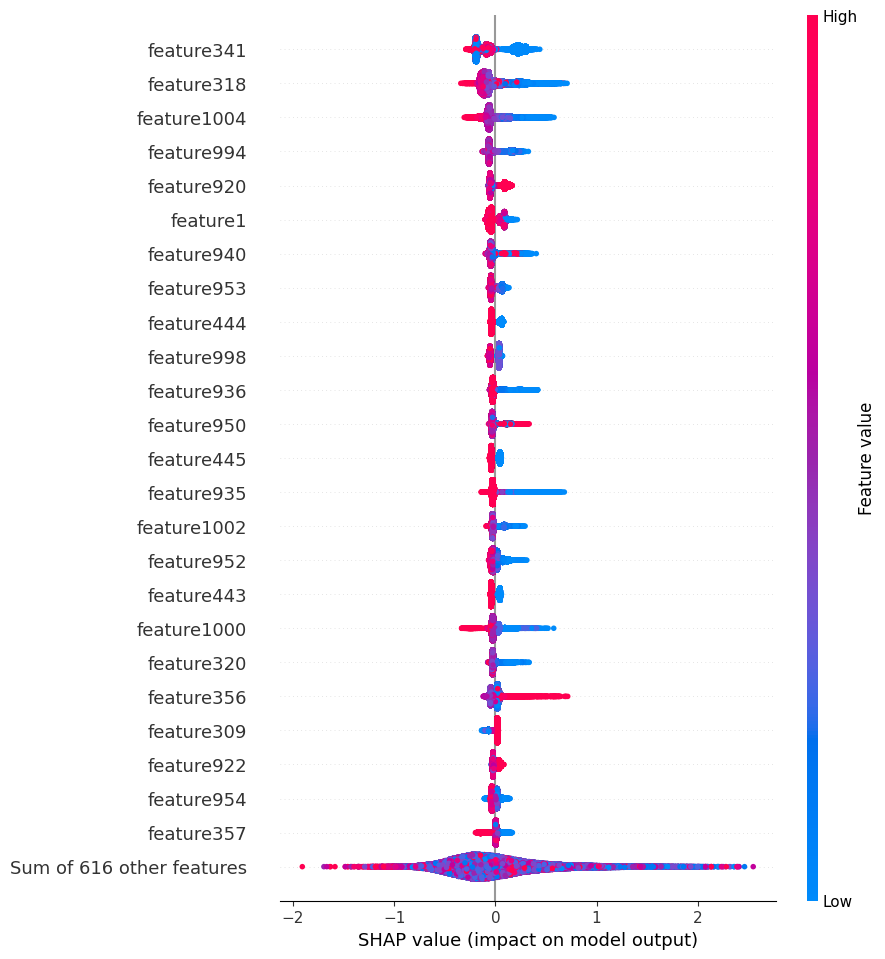

In [15]:
# look at shap_values for the last catboost model
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_sampled)

shap.plots.beeswarm(shap_values, max_display=25)

In [16]:
%%time

data_test = pl.read_parquet(DATA_PATH + 'data_test_cleaned.parquet')

X_test = data_test.drop('target').to_pandas()

y_pred_list, y_pred_binary_list = [], []
for model in models:
    y_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
    y_pred_binary = (y_pred > round(18_537 / 100_000, 3)).astype(int)

    y_pred_list.append(y_pred)
    y_pred_binary_list.append(y_pred_binary)

y_pred_final = np.concatenate(y_pred_list, axis=1).mean(axis=1)
y_pred_binary_final = np.concatenate(y_pred_binary_list, axis=1).mean(axis=1).round().astype(int)

CPU times: user 47 s, sys: 1.6 s, total: 48.6 s
Wall time: 32 s


In [17]:
submission = pl.read_parquet(DATA_PATH + 'test_sber.parquet').select('id').to_pandas()

submission['target_prob'] = y_pred_final
submission['target_bin'] = y_pred_binary_final

submission.to_csv('submission_3_ensemble_catboost.csv', index=False)
submission.head(3)

,id,target_prob,target_bin
0,3,0.067314,0
1,4,0.094904,0
2,12,0.150552,0


## 2. LightGBM ensembling

In [18]:
models_gbm = []
for chunk in chunks:
    Xy_train = pl.concat([chunk, data_only_1], how='vertical').to_pandas()

    X_train_sampled, y_train_sampled = Xy_train.drop(columns=['target']), Xy_train['target'].values

    model = LGBMClassifier()
    model.fit(X_train_sampled, y_train_sampled)

    models_gbm.append(model)

[LightGBM] [Info] Number of positive: 18537, number of negative: 100000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.367938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97588
[LightGBM] [Info] Number of data points in the train set: 118537, number of used features: 639
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156382 -> initscore=-1.685401
[LightGBM] [Info] Start training from score -1.685401
[LightGBM] [Info] Number of positive: 18537, number of negative: 100000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.358734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97466
[LightGBM] [Info] Number of data points in the train set: 118537, number of used features: 639
[LightGBM]

In [19]:
for i, model in enumerate(models_gbm):
    model.booster_.save_model(f'model_lgbm_{i}.txt')

In [20]:
%%time

data_test = pl.read_parquet(DATA_PATH + 'data_test_cleaned.parquet')

X_test = data_test.drop('target').to_pandas()

y_pred_list, y_pred_binary_list = [], []
for model in models_gbm:
    y_pred = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
    y_pred_binary = (y_pred > round(18_537 / 100_000, 3)).astype(int)

    y_pred_list.append(y_pred)
    y_pred_binary_list.append(y_pred_binary)

y_pred_final = np.concatenate(y_pred_list, axis=1).mean(axis=1)
y_pred_binary_final = np.concatenate(y_pred_binary_list, axis=1).mean(axis=1).round().astype(int)

CPU times: user 14.6 s, sys: 3.03 s, total: 17.7 s
Wall time: 9.69 s


In [21]:
submission = pl.read_parquet(DATA_PATH + 'test_sber.parquet').select('id').to_pandas()

submission['target_prob'] = y_pred_final
submission['target_bin'] = y_pred_binary_final

submission.to_csv('submission_3_ensemble_lgbm.csv', index=False)
submission.head(3)

,id,target_prob,target_bin
0,3,0.071497,0
1,4,0.092284,0
2,12,0.246471,1


## 3. Ensemble both (with different weights)

In [22]:
submission_catboost = pd.read_csv('submission_3_ensemble_catboost.csv')
submission_lgbm = pd.read_csv('submission_3_ensemble_lgbm.csv')

submission_1 = submission_catboost[['id']]
submission_2 = submission_catboost[['id']]
submission_3 = submission_catboost[['id']]
submission_4 = submission_catboost[['id']]

In [23]:
submission_1['target_prob'] = 0.50 * submission_catboost['target_prob'] + 0.50 * submission_lgbm['target_prob']
submission_1['target_bin'] = (submission_1['target_prob'] >= 0.5).astype(int)

submission_2['target_prob'] = 0.75 * submission_catboost['target_prob'] + 0.25 * submission_lgbm['target_prob']
submission_2['target_bin'] = (submission_2['target_prob'] >= 0.5).astype(int)

submission_3['target_prob'] = 0.90 * submission_catboost['target_prob'] + 0.10 * submission_lgbm['target_prob']
submission_3['target_bin'] = (submission_3['target_prob'] >= 0.5).astype(int)

submission_4['target_prob'] = 1.00 * submission_catboost['target_prob'] + 0.00 * submission_lgbm['target_prob']
submission_4['target_bin'] = (submission_4['target_prob'] >= 0.5).astype(int)

submission_1.to_csv('submission_3_ensemble_50catboost_plus_50lgbm.csv', index=False)
submission_2.to_csv('submission_3_ensemble_75catboost_plus_25lgbm.csv', index=False)
submission_3.to_csv('submission_3_ensemble_90catboost_plus_10lgbm.csv', index=False)
submission_4.to_csv('submission_3_ensemble_catboost_with_another_threshold.csv', index=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/